## Курсовая работа по теме: Распознавание мошеннических действий с кредитными картами при помощи нейронных сетей

###  Выполнила: Палагутина Варвара. 
#### Студентка 1 курса направления 02.04.03 «Математическое обеспечение и администрирование информационных систем», профиль обучения «Банковские информационные технологии»

## Описание работы
Для решения проблемы нахождения мошеннических транзакций среди огромного количества данных необходимо использовать методы машинного обучения или нейронные сети. В своей работе я рассмотрела различные методы машинного обучения, а именно логистическая регессия, случайный лес, деревья решений и XGBoost. Далее создается и обучаеся модель полносвязных нейронных сетей и выводятся результаты по каждому из вариантов обучения для сравнения.
В результате работы можно сделать вывод, что хотя и XGBoost показывает самые лучшие результаты предсказания он все-равно недостаточно точный для работы с реальными данными.

Ссылка на датасет: https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions?datasetId=1478095

### LICENSE

Докумет LICENSE приложен к zip файлу, в котором отправляется работа. LICENSE-2.0.txt

Copyright 2023 Палагутина Варвара Дмитриевна

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### Установка библиотек

In [1]:
import numpy as np                               # работа с векторами и матрицами
import pandas as pd                              # таблицы и операции над данными
import matplotlib.pyplot as plt                  # графики
import seaborn as sns     

In [2]:
from dateutil.relativedelta import relativedelta # для комфортной работы с датами
from scipy.optimize import minimize              # позволяет минимизировать функции

import statsmodels.formula.api as smf            # статистика и эконометрика
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

from itertools import product                    # немножко функций для удобства
from tqdm import tqdm_notebook

import warnings                                  # чтобы никто не мешал
warnings.filterwarnings('ignore')

%matplotlib inline

### Обработаем данные

In [3]:
tranz = pd.read_csv('credit_card_transactions-ibm_v2.csv')

In [4]:
tranz = tranz.drop(['Merchant State', 'Zip'], axis=1)

In [5]:
tranz.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,5912,NaN,No


In [6]:
tranz["Amount"] = tranz["Amount"].astype(str).str.replace("$","").astype(float)
tranz["Use Chip"]=LabelEncoder().fit_transform(tranz["Use Chip"])
tranz["Merchant City"]=LabelEncoder().fit_transform(tranz["Merchant City"])
tranz["Errors?"]= tranz["Errors?"].fillna("No error")
tranz["Errors?"]=LabelEncoder().fit_transform(tranz["Errors?"])
tranz["Is Fraud?"] = tranz["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

In [7]:
tranz.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,134.09,2,3527213246127876953,6274,5300,22,0
1,0,0,2002,9,1,06:42,38.48,2,-727612092139916043,7827,5411,22,0
2,0,0,2002,9,2,06:22,120.34,2,-727612092139916043,7827,5411,22,0
3,0,0,2002,9,2,17:45,128.95,2,3414527459579106770,7827,5651,22,0
4,0,0,2002,9,3,06:23,104.71,2,5817218446178736267,6274,5912,22,0


In [8]:
tranz['Time'] = pd.to_datetime(tranz['Time'])

In [9]:
tranz.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,2023-05-09 06:21:00,134.09,2,3527213246127876953,6274,5300,22,0
1,0,0,2002,9,1,2023-05-09 06:42:00,38.48,2,-727612092139916043,7827,5411,22,0
2,0,0,2002,9,2,2023-05-09 06:22:00,120.34,2,-727612092139916043,7827,5411,22,0
3,0,0,2002,9,2,2023-05-09 17:45:00,128.95,2,3414527459579106770,7827,5651,22,0
4,0,0,2002,9,3,2023-05-09 06:23:00,104.71,2,5817218446178736267,6274,5912,22,0


### Изменим часы на время суток

In [10]:
times = {
    'morning': range(6, 12),
    'day': range(12, 18),
    'evening': range(18, 24),
    'night': range(0, 6)
}
def get_time_interval(time):
    for key, value in times.items():
        if time.hour in value:
            return key
tranz['Time_interval'] = tranz['Time'].apply(get_time_interval)

In [11]:
tranz.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,MCC,Errors?,Is Fraud?,Time_interval
0,0,0,2002,9,1,2023-05-09 06:21:00,134.09,2,3527213246127876953,6274,5300,22,0,morning
1,0,0,2002,9,1,2023-05-09 06:42:00,38.48,2,-727612092139916043,7827,5411,22,0,morning
2,0,0,2002,9,2,2023-05-09 06:22:00,120.34,2,-727612092139916043,7827,5411,22,0,morning
3,0,0,2002,9,2,2023-05-09 17:45:00,128.95,2,3414527459579106770,7827,5651,22,0,day
4,0,0,2002,9,3,2023-05-09 06:23:00,104.71,2,5817218446178736267,6274,5912,22,0,morning


In [12]:
tranz

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,MCC,Errors?,Is Fraud?,Time_interval
0,0,0,2002,9,1,2023-05-09 06:21:00,134.09,2,3527213246127876953,6274,5300,22,0,morning
1,0,0,2002,9,1,2023-05-09 06:42:00,38.48,2,-727612092139916043,7827,5411,22,0,morning
2,0,0,2002,9,2,2023-05-09 06:22:00,120.34,2,-727612092139916043,7827,5411,22,0,morning
3,0,0,2002,9,2,2023-05-09 17:45:00,128.95,2,3414527459579106770,7827,5651,22,0,day
4,0,0,2002,9,3,2023-05-09 06:23:00,104.71,2,5817218446178736267,6274,5912,22,0,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,2,27,2023-05-09 22:23:00,-54.00,0,-5162038175624867091,7555,5541,22,0,evening
24386896,1999,1,2020,2,27,2023-05-09 22:24:00,54.00,0,-5162038175624867091,7555,5541,22,0,evening
24386897,1999,1,2020,2,28,2023-05-09 07:43:00,59.15,0,2500998799892805156,7555,4121,22,0,morning
24386898,1999,1,2020,2,28,2023-05-09 20:10:00,43.12,0,2500998799892805156,7555,4121,22,0,evening


In [13]:
del tranz['Time']

In [14]:
tranz["Time_interval"]=tranz["Time_interval"].replace({'night':0,'morning':1,'day':2,'evening':3})

<AxesSubplot:>

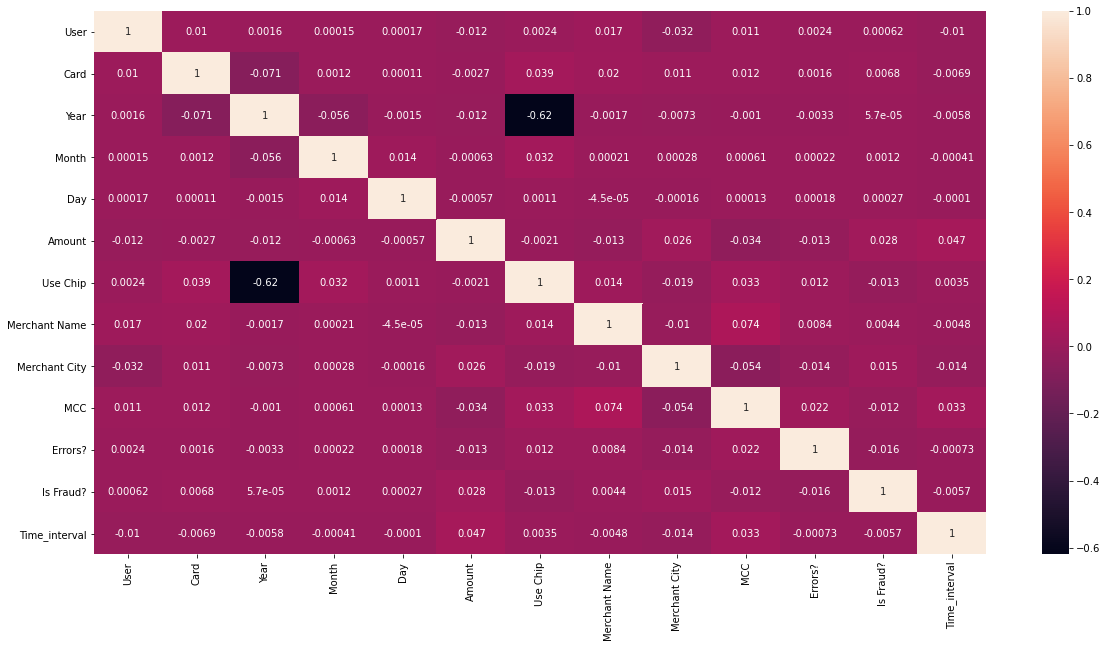

In [15]:
plt.figure(figsize=(20,10)) 
sns.heatmap(tranz.corr(), annot=True)

In [16]:
tranz = tranz[tranz['Year']>2007]

In [17]:
tranz['User'].value_counts()

1249    59373
262     53662
1101    52337
396     50500
332     49778
        ...  
231        21
1367       20
1767       16
1817       15
1440        2
Name: User, Length: 1993, dtype: int64

In [18]:
tranz.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19490467 entries, 1899 to 24386899
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   User           int64  
 1   Card           int64  
 2   Year           int64  
 3   Month          int64  
 4   Day            int64  
 5   Amount         float64
 6   Use Chip       int32  
 7   Merchant Name  int64  
 8   Merchant City  int32  
 9   MCC            int64  
 10  Errors?        int32  
 11  Is Fraud?      int64  
 12  Time_interval  int64  
dtypes: float64(1), int32(3), int64(9)
memory usage: 1.8 GB


### Создадим равновесную выборку

In [19]:
test = tranz[tranz['Is Fraud?']==1].iloc[:20000].copy()
test2= tranz[tranz['Is Fraud?']==0].iloc[:20000].copy()
test_cut = pd.concat([test, test2])
shuffled_test = test_cut.sample(frac=1)

In [20]:
shuffled_test = shuffled_test.drop(['User'], axis=1)

In [21]:
shuffled_test

,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,MCC,Errors?,Is Fraud?,Time_interval
18836345,2,2008,2,4,167.52,1,7272219750676920057,8656,5193,22,1,1
8659971,3,2018,7,12,128.49,0,-8830141029664022553,10300,5211,14,1,2
20443,1,2013,6,28,42.30,2,6698459923198770712,4270,4814,22,0,2
4836707,3,2018,9,24,103.68,0,590183032319022035,10300,5094,22,1,3
19570,3,2019,6,21,34.05,2,-5023497618971072366,7737,5812,22,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
16424179,6,2018,2,7,156.88,0,4573875080712571902,10300,5045,22,1,2
3564,0,2013,8,19,37.82,2,4060646732831064559,6274,5411,22,0,1
14690,3,2010,8,17,10.04,2,-5023497618971072366,7737,5812,22,0,2
15928555,1,2015,4,29,37.66,1,5232804510082391016,8656,5814,22,1,1


In [22]:
shuffled_test['Is Fraud?'].value_counts()

1    20000
0    20000
Name: Is Fraud?, dtype: int64

### Создадим дополнительную выборку для дополнительной проверки как на настоящих данных

In [23]:
itogo = tranz.iloc[-1000:].copy()
itogo_tf = test[test['Is Fraud?']==1].iloc[:1].copy()
itogo = pd.concat([itogo, itogo_tf])
itogo_res = itogo['Is Fraud?']
itogo = itogo.drop(['Is Fraud?', 'User'], axis=1)

In [24]:
itogo_res.value_counts()

0    1000
1       1
Name: Is Fraud?, dtype: int64

In [25]:
itogo.value_counts() #проверим данные

Card  Year  Month  Day  Amount  Use Chip  Merchant Name         Merchant City  MCC   Errors?  Time_interval
1     2020  2      28   59.15   0          2500998799892805156  7555           4121  22       1                1
      2019  9      11   57.78   1         -4241409341442030551  8656           7349  22       2                1
                   14   57.57   0          1799189980464955940  7555           5499  22       3                1
                        50.43   0          2500998799892805156  7555           4121  22       1                1
                        44.98   0          2500998799892805156  7555           4121  22       3                1
                                                                                                              ..
            11     28   44.47   0          3597605838047626910  7555           5813  22       3                1
                        26.01   0          2500998799892805156  7555           4121  22       3      

In [26]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [27]:
x1 = shuffled_test.drop(['Is Fraud?'], axis=1)
y1 = shuffled_test['Is Fraud?']
sc.fit(x1.values)
X_ans = sc.transform(x1.values)
X_ans

array([[ 0.16939978, -1.5279633 , -1.3029264 , ..., -0.25831407,
         0.12851314, -0.70123621],
       [ 0.91829359,  1.25809204,  0.13992802, ..., -0.23924114,
        -3.94682174,  0.59190142],
       [-0.57949403, -0.13493563, -0.14864286, ..., -0.65990507,
         0.12851314,  0.59190142],
       ...,
       [ 0.91829359, -0.97075223,  0.4284989 , ...,  0.3975826 ,
         0.12851314,  0.59190142],
       [-0.57949403,  0.42227544, -0.72578463, ...,  0.39970181,
         0.12851314, -0.70123621],
       [ 0.91829359,  0.14366991,  1.00564067, ...,  0.50354328,
         0.12851314, -0.70123621]])

In [28]:
# y = tranz['Is Fraud?'] #выделяем целевую переменную из общего объема данных
# X = tranz.drop('Is Fraud?', axis=1) #удаляем целевую переменную из обучающего множества
# sc = StandardScaler()
# sc.fit(X)
# X_ans = sc.transform(X)

In [29]:
itogo = sc.transform(itogo.values)

In [30]:
# from sklearn.model_selection import train_test_split, StratifiedKFold, validation_curve
# from sklearn import svm #импортируем нашу модель
# X_train, X_test, y_train, y_test = train_test_split(X_ans, y, test_size=0.2, random_state=42) # разбиваем множества

In [31]:
from sklearn.model_selection import train_test_split, StratifiedKFold, validation_curve

X_train, X_test, y_train, y_test = train_test_split(X_ans, y1.values, test_size=0.2, random_state=42) # разбиваем множества

In [32]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (32000, 11)
Shape of y_train: (32000,)


### Воспользуемся методами машинного обучения

### Логистическая регессия

In [33]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import precision_score
LogisticRegression_model = LogisticRegression(max_iter=10000)
LogisticRegression_model.fit(X_train, y_train)
LogisticRegression_predict = LogisticRegression_model.predict(X_test)

In [34]:
precision_score(y_test, LogisticRegression_predict)
print(classification_report(y_test, LogisticRegression_predict))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      3995
           1       0.83      0.87      0.85      4005

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000



In [35]:
LogisticRegression_predict_itogo = LogisticRegression_model.predict(itogo)    
precision_score(itogo_res, LogisticRegression_predict_itogo)
print(classification_report(itogo_res, LogisticRegression_predict_itogo))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86      1000
           1       0.00      1.00      0.01         1

    accuracy                           0.75      1001
   macro avg       0.50      0.88      0.43      1001
weighted avg       1.00      0.75      0.86      1001



### Деревья решений

In [36]:
from sklearn.tree import DecisionTreeClassifier #импортируем модель деревьев решений
from sklearn import metrics

In [37]:
DecisionTreeClassifier_model = DecisionTreeClassifier(random_state=123, min_samples_split=28) # инициализируем модель

In [38]:
DecisionTreeClassifier_model.fit(X_train, y_train)                    # обучаем модель
predicted_DecisionTreeClassifier = DecisionTreeClassifier_model.predict(X_test)    

In [39]:
precision_score(y_test, predicted_DecisionTreeClassifier)
print(classification_report(y_test, predicted_DecisionTreeClassifier))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3995
           1       0.97      0.96      0.97      4005

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000



In [40]:
predicted_DecisionTreeClassifier_itogo = DecisionTreeClassifier_model.predict(itogo)    
precision_score(itogo_res, predicted_DecisionTreeClassifier_itogo)
print(classification_report(itogo_res, predicted_DecisionTreeClassifier_itogo))

              precision    recall  f1-score   support

           0       1.00      0.72      0.84      1000
           1       0.00      1.00      0.01         1

    accuracy                           0.72      1001
   macro avg       0.50      0.86      0.42      1001
weighted avg       1.00      0.72      0.84      1001



### Случайный лес

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
RandomForest_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

In [43]:
RandomForest_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [44]:
predicted_RandomForest = RandomForest_model.predict(X_test)    
precision_score(y_test, predicted_RandomForest)
print(classification_report(y_test, predicted_RandomForest))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      3995
           1       0.89      0.92      0.91      4005

    accuracy                           0.90      8000
   macro avg       0.91      0.90      0.90      8000
weighted avg       0.91      0.90      0.90      8000



In [45]:
predicted_RandomForest_itogo = RandomForest_model.predict(itogo)    
precision_score(itogo_res, predicted_RandomForest_itogo)
print(classification_report(itogo_res, predicted_RandomForest_itogo))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80      1000
           1       0.00      1.00      0.01         1

    accuracy                           0.67      1001
   macro avg       0.50      0.84      0.41      1001
weighted avg       1.00      0.67      0.80      1001



### XGBoost

In [46]:
from xgboost import XGBRegressor 

In [47]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [48]:
predicted_xgb = xgb.predict(X_test)   # делаем предсказание

In [49]:
pred_xgb = np.asarray([abs(round(line, 0)) for line in predicted_xgb])
print ("accuracy score model: ", metrics.accuracy_score(pred_xgb, y_test))
print ("classification_report model:\n ", metrics.classification_report(y_test, pred_xgb))

accuracy score model:  0.984875
classification_report model:
                precision    recall  f1-score   support

           0       0.99      0.98      0.98      3995
           1       0.98      0.99      0.98      4005

    accuracy                           0.98      8000
   macro avg       0.98      0.98      0.98      8000
weighted avg       0.98      0.98      0.98      8000



In [50]:
predicted_xgb_itogo = xgb.predict(itogo)   # делаем предсказание
pred_xgb_itogo = np.asarray([abs(round(line, 0)) for line in predicted_xgb_itogo])
print ("accuracy score model: ", metrics.accuracy_score(pred_xgb_itogo, itogo_res))
print ("classification_report model:\n ", metrics.classification_report(itogo_res, pred_xgb_itogo))

accuracy score model:  0.8821178821178821
classification_report model:
                precision    recall  f1-score   support

           0       1.00      0.88      0.94      1000
           1       0.01      1.00      0.02         1

    accuracy                           0.88      1001
   macro avg       0.50      0.94      0.48      1001
weighted avg       1.00      0.88      0.94      1001



### Нейронная сеть

In [51]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import LSTM, TimeDistributed, Conv1D, MaxPooling1D, Flatten, GlobalMaxPooling1D, Embedding, Input, Reshape, Dropout, BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping

In [52]:
early_stopping = EarlyStopping(patience=5) # остановка обучения, если качество не улучшается в течение 5 эпох

T= X_train.shape[1]
model = Sequential([
    Input(shape=(T)),
    Dense(5, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dense(5, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [53]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history_model = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                          validation_split=0.2, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 60        
                                                                 
 batch_normalization (BatchN  (None, 5)                20        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 116
Trainable params: 106
Non-trainable params: 10
_________________________________________________________________
Epoch 1/200
800/800 [==============================] - 1s 1ms/step - loss: 0.5961 - accuracy: 0.6948 - val_loss: 0.3514 - v

In [54]:
# plot_model(model), to_file='model_CNN_plot.png', 
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
#     show_trainable=False,
# )

In [55]:
# Оценка производительности модели на тестовой выборке
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.2452635020017624
Test accuracy: 0.9120000004768372


In [56]:
history_model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Построим графики обучения нейронной сети

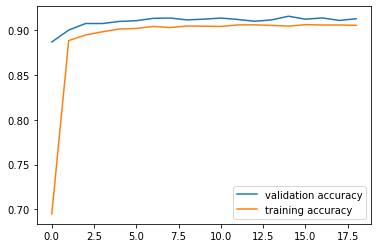

In [57]:
plt.plot(history_model.history['val_accuracy'], label='validation accuracy')
plt.plot(history_model.history['accuracy'], label='training accuracy')
plt.legend();

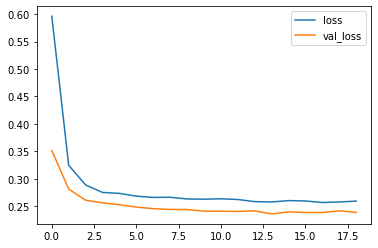

In [58]:
plt.plot(history_model.history['loss'], label='loss')
plt.plot(history_model.history['val_loss'], label='val_loss')
plt.legend();

In [59]:
predict=model.predict(X_test)
predict

250/250 [==============================] - 0s 542us/step


array([[0.96895736],
       [0.00827238],
       [0.48836097],
       ...,
       [0.5829551 ],
       [0.8819128 ],
       [0.97972417]], dtype=float32)

In [60]:
predict=np.rint(predict)
predict=np.int64(predict)
predict

array([[1],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]], dtype=int64)

In [61]:
print(classification_report(y_test, predict.reshape(-1)))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      3995
           1       0.90      0.93      0.91      4005

    accuracy                           0.91      8000
   macro avg       0.91      0.91      0.91      8000
weighted avg       0.91      0.91      0.91      8000



In [62]:
predict_itogo=model.predict(itogo)
predict_itogo

32/32 [==============================] - 0s 581us/step


array([[0.75383836],
       [0.74446255],
       [0.88268733],
       ...,
       [0.06329267],
       [0.0808285 ],
       [0.9682325 ]], dtype=float32)

In [63]:
predict_itogo=np.rint(predict_itogo)
predict_itogo=np.int64(predict_itogo)
predict_itogo

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]], dtype=int64)

In [64]:
print(classification_report(itogo_res, predict_itogo))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80      1000
           1       0.00      1.00      0.01         1

    accuracy                           0.67      1001
   macro avg       0.50      0.84      0.41      1001
weighted avg       1.00      0.67      0.80      1001

